In [29]:
# Import necessary libraries
import pandas as pd  # pandas is a library for data manipulation and analysis
from sklearn.model_selection import train_test_split, GridSearchCV  # scikit-learn provides tools for machine learning tasks
from sklearn.preprocessing import StandardScaler  # StandardScaler is used for feature scaling
from sklearn.svm import SVR  # Support Vector Regression (SVR) is a regression algorithm in scikit-learn
import joblib # joblib is used to save and load models



In [12]:
data = pd.read_csv("data_concrete.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Grade                      96 non-null     object 
 1   Glass Fibre (%)            96 non-null     float64
 2   Number of Days             96 non-null     int64  
 3   Comp_Strength (N/mm2)      96 non-null     float64
 4   Flex_strenght(N/mm2)       96 non-null     float64
 5   Splitting Strength(N/mm2)  96 non-null     float64
dtypes: float64(4), int64(1), object(1)
memory usage: 4.6+ KB


# Compression strength model


In [4]:
# Reading the data from a file into a table
data = pd.read_csv("data_concrete.csv")  # Put your file path here

# Keeping only important columns
data_comp = data[['Grade', 'Number of Days', 'Glass Fibre (%)', 'Comp_Strength (N/mm2)']]

# Changing 'Number of Days' into categories
data_comp['Number of Days'] = data_comp['Number of Days'].astype(str)

# Changing 'Grade' into numbers
data_comp_with_dummies = pd.get_dummies(data_comp, columns=['Grade', 'Number of Days'])

# Separating features and results
X = data_comp_with_dummies.drop(['Comp_Strength (N/mm2)'], axis=1)  # Features
y = data_comp_with_dummies['Comp_Strength (N/mm2)']  # Results

# Scaling numbers to make them easier to work with
numeric_features = ['Glass Fibre (%)']  # The numbers we want to scale
numeric_transformer = StandardScaler()  # The tool for scaling

# Applying scaling to the numbers
X[numeric_features] = numeric_transformer.fit_transform(X[numeric_features])  # Scaling the numbers
print(X.columns)  # Showing the column names after scaling

# Splitting the data into training and testing parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Splitting the data

Index(['Glass Fibre (%)', 'Grade_M20', 'Grade_M30', 'Grade_M40', 'Grade_M50',
       'Number of Days_180', 'Number of Days_28', 'Number of Days_360',
       'Number of Days_56', 'Number of Days_7', 'Number of Days_90'],
      dtype='object')


C:\Users\karthik rathod\AppData\Local\Temp\ipykernel_38200\983093811.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_comp['Number of Days'] = data_comp['Number of Days'].astype(str)


In [5]:
# Define the SVM model
svm_model_comp = SVR()  # Creating a Support Vector Regression model

# Define a grid of parameters to search
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Types of mathematical functions used for modeling
    'C': [0.1, 1, 10],  # Penalty parameter for regularization (controls the trade-off between smooth decision boundary and classifying the training points correctly)
    'gamma': ['scale', 'auto'],  # Kernel coefficient (scale: uses 1 / (n_features * X.var()) as gamma, auto: uses 1 / n_features)
    'degree': [2, 3, 4]  # Degree of the polynomial kernel function (only used for 'poly' kernel)
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=svm_model_comp, param_grid=param_grid, cv=5, n_jobs=-1)
# GridSearchCV: Searching for the best combination of hyperparameters by trying all possible combinations
# estimator: The model to be tuned (SVR in this case)
# param_grid: The grid of parameters to search
# cv: Number of folds in cross-validation (5-fold cross-validation used here)
# n_jobs: Number of jobs to run in parallel (-1 means using all available processors)

grid_search.fit(X_train, y_train)  # Fitting the model with different combinations of parameters

# Get the best parameters
best_params_comp = grid_search.best_params_  # Finding the combination that gives the best performance
print("Best Parameters:", best_params_comp)

# Evaluate the model with the best parameters
best_model_comp = grid_search.best_estimator_  # Using the best parameters to create the final model
test_score = best_model_comp.score(X_test, y_test)  # Evaluating the final model on the test data
print(f"Test Score: {test_score}")  # Printing the performance of the model on the test data


Best Parameters: {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}
Test Score: 0.9697106730765775


In [30]:
# Save the best model to a file
joblib.dump(best_model_comp, 'svm_best_model_comp.pkl')


['svm_best_model_comp.pkl']

In [6]:
def predict_with_best_model_comp(grade, num_days, glass_fibre, best_model_comp):
    """
    Predict using the best model found during grid search.

    Parameters:
    - grade: Grade (categorical)
    - num_days: Number of Days (categorical)
    - glass_fibre: Glass Fibre (%) (numerical)
    - best_model: Fitted SVM model with the best parameters

    Returns:
    - prediction: Predicted value
    """
    # Create a DataFrame with the input data
    input_data = pd.DataFrame({
        'Grade': [grade],  # Creating a DataFrame with a single row containing the 'grade' input
        'Number of Days': [num_days],  # Adding 'num_days' input to the DataFrame
        'Glass Fibre (%)': [glass_fibre]  # Adding 'glass_fibre' input to the DataFrame
    })

    # Normalize numerical variables
    numeric_features = ['Glass Fibre (%)']  # List of numerical features to be scaled
    numeric_transformer = StandardScaler()  # Creating a StandardScaler object
    input_data[numeric_features] = numeric_transformer.fit_transform(input_data[numeric_features])  # Scaling numerical features

    # Convert categorical variables into dummy variables
    input_data = pd.get_dummies(input_data, columns=['Grade', 'Number of Days'])  # Converting categorical variables into dummy variables

    # Ensure all grade columns are present
    grade_columns = ['Glass Fibre (%)', 'Grade_M20', 'Grade_M30', 'Grade_M40', 'Grade_M50',
       'Number of Days_180', 'Number of Days_28', 'Number of Days_360',
       'Number of Days_56', 'Number of Days_7', 'Number of Days_90']  # List of expected grade columns
    for col in grade_columns:
        if col not in input_data.columns:
            input_data[col] = 0  # Adding missing columns with default value 0

    # Reorder columns to match the order during training
    input_data = input_data[grade_columns]  # Reordering columns to match the order during training

    # Make prediction
    prediction = best_model_comp.predict(input_data)  # Making prediction using the best model and input data

    return prediction  # Returning the predicted value


In [7]:
# Example usage:
predicted_value = predict_with_best_model_comp('M30', '90', 0.3, best_model_comp)
# Using the function to predict the outcome for a specific set of inputs
# Parameters: Grade = 'M30', Number of Days = '90', Glass Fibre (%) = 0%
print(f"Predicted value: {predicted_value}")
# Printing the predicted value


Predicted value: [55.28872145]


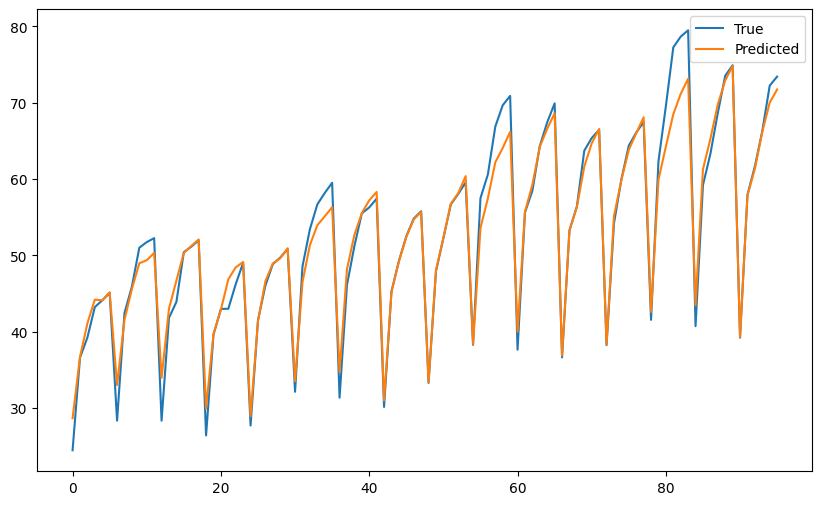

In [10]:
import matplotlib.pyplot as plt  # Importing the matplotlib library for plotting

# Get the predictions using the best model
y_pred = best_model_comp.predict(X)  # Making predictions on the input data

# Plot the true and predicted values
plt.figure(figsize=(10, 6))  # Creating a plot with a specified size
plt.plot(y, label='True')  # Plotting the true values
plt.plot(y_pred, label='Predicted')  # Plotting the predicted values
plt.legend()  # Adding a legend to the plot
plt.show()  # Displaying the plot


# Flex_strenght model

In [16]:
# Reading the data from a file into a table
data_flex = pd.read_csv("data_concrete.csv")  # Put your file path here

# Keeping only important columns
data_split = data_flex[['Grade', 'Number of Days', 'Glass Fibre (%)', 'Flex_strenght(N/mm2)']]

# Changing 'Number of Days' into categories
data_flex['Number of Days'] = data_flex['Number of Days'].astype(str)

# Changing 'Grade' into numbers
data_flex_with_dummies = pd.get_dummies(data_flex, columns=['Grade', 'Number of Days'])

# Separating features and results
X = data_flex_with_dummies.drop(['Flex_strenght(N/mm2)'], axis=1)  # Features
y = data_flex_with_dummies['Flex_strenght(N/mm2)']  # Results

# Scaling numbers to make them easier to work with
numeric_features = ['Glass Fibre (%)']  # The numbers we want to scale
numeric_transformer = StandardScaler()  # The tool for scaling

# Applying scaling to the numbers
X[numeric_features] = numeric_transformer.fit_transform(X[numeric_features])  # Scaling the numbers
print(X.columns)  # Showing the column names after scaling

# Splitting the data into training and testing parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Splitting the data

Index(['Glass Fibre (%)', 'Grade_M20', 'Grade_M30', 'Grade_M40', 'Grade_M50',
       'Number of Days_180', 'Number of Days_28', 'Number of Days_360',
       'Number of Days_56', 'Number of Days_7', 'Number of Days_90'],
      dtype='object')


In [17]:
# Define the SVM model
svm_model_flex = SVR()  # Creating a Support Vector Regression model

# Define a grid of parameters to search
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Types of mathematical functions used for modeling
    'C': [0.1, 1, 10],  # Penalty parameter for regularization (controls the trade-off between smooth decision boundary and classifying the training points correctly)
    'gamma': ['scale', 'auto'],  # Kernel coefficient (scale: uses 1 / (n_features * X.var()) as gamma, auto: uses 1 / n_features)
    'degree': [2, 3, 4]  # Degree of the polynomial kernel function (only used for 'poly' kernel)
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=svm_model_flex, param_grid=param_grid, cv=5, n_jobs=-1)
# GridSearchCV: Searching for the best combination of hyperparameters by trying all possible combinations
# estimator: The model to be tuned (SVR in this case)
# param_grid: The grid of parameters to search
# cv: Number of folds in cross-validation (5-fold cross-validation used here)
# n_jobs: Number of jobs to run in parallel (-1 means using all available processors)

grid_search.fit(X_train, y_train)  # Fitting the model with different combinations of parameters

# Get the best parameters
best_params_flex = grid_search.best_params_  # Finding the combination that gives the best performance
print("Best Parameters:", best_params_flex)

# Evaluate the model with the best parameters
best_model_flex = grid_search.best_estimator_  # Using the best parameters to create the final model
test_score = best_model_flex.score(X_test, y_test)  # Evaluating the final model on the test data
print(f"Test Score: {test_score}")  # Printing the performance of the model on the test data


Best Parameters: {'C': 10, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}
Test Score: 0.9810456843549603


In [31]:
# Save the best model to a file
joblib.dump(best_model_flex, 'svm_best_model_flex.pkl')


['svm_best_model_flex.pkl']

In [20]:
def predict_with_best_model_flex(grade, num_days, glass_fibre, best_model_flex):
    """
    Predict using the best model found during grid search.

    Parameters:
    - grade: Grade (categorical)
    - num_days: Number of Days (categorical)
    - glass_fibre: Glass Fibre (%) (numerical)
    - best_model: Fitted SVM model with the best parameters

    Returns:
    - prediction: Predicted value
    """
    # Create a DataFrame with the input data
    input_data = pd.DataFrame({
        'Grade': [grade],  # Creating a DataFrame with a single row containing the 'grade' input
        'Number of Days': [num_days],  # Adding 'num_days' input to the DataFrame
        'Glass Fibre (%)': [glass_fibre]  # Adding 'glass_fibre' input to the DataFrame
    })

    # Normalize numerical variables
    numeric_features = ['Glass Fibre (%)']  # List of numerical features to be scaled
    numeric_transformer = StandardScaler()  # Creating a StandardScaler object
    input_data[numeric_features] = numeric_transformer.fit_transform(input_data[numeric_features])  # Scaling numerical features

    # Convert categorical variables into dummy variables
    input_data = pd.get_dummies(input_data, columns=['Grade', 'Number of Days'])  # Converting categorical variables into dummy variables

    # Ensure all grade columns are present
    grade_columns = ['Glass Fibre (%)', 'Grade_M20', 'Grade_M30', 'Grade_M40', 'Grade_M50',
       'Number of Days_180', 'Number of Days_28', 'Number of Days_360',
       'Number of Days_56', 'Number of Days_7', 'Number of Days_90']  # List of expected grade columns
    for col in grade_columns:
        if col not in input_data.columns:
            input_data[col] = 0  # Adding missing columns with default value 0

    # Reorder columns to match the order during training
    input_data = input_data[grade_columns]  # Reordering columns to match the order during training

    # Make prediction
    prediction = best_model_flex.predict(input_data)  # Making prediction using the best model and input data

    return prediction  # Returning the predicted value


In [21]:
# Example usage:
predicted_value = predict_with_best_model_flex('M30', '90', 0., best_model_flex)
# Using the function to predict the outcome for a specific set of inputs
# Parameters: Grade = 'M30', Number of Days = '90', Glass Fibre (%) = 0%
print(f"Predicted value: {predicted_value}")
# Printing the predicted value


Predicted value: [5.60058862]


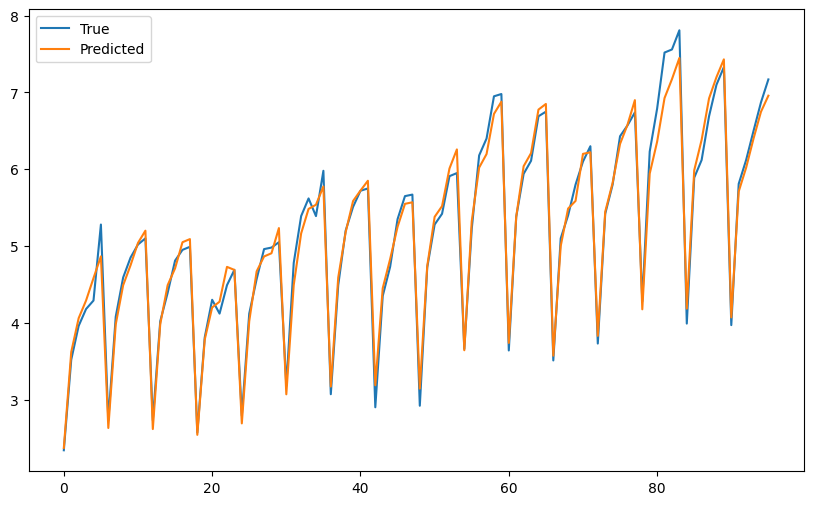

In [22]:
import matplotlib.pyplot as plt  # Importing the matplotlib library for plotting

# Get the predictions using the best model
y_pred = best_model_flex.predict(X)  # Making predictions on the input data

# Plot the true and predicted values
plt.figure(figsize=(10, 6))  # Creating a plot with a specified size
plt.plot(y, label='True')  # Plotting the true values
plt.plot(y_pred, label='Predicted')  # Plotting the predicted values
plt.legend()  # Adding a legend to the plot
plt.show()  # Displaying the plot


# Splitting Strength model

In [23]:
# Reading the data from a file into a table
data_split = pd.read_csv("data_concrete.csv")  # Put your file path here

# Keeping only important columns
data_split = data_split[['Grade', 'Number of Days', 'Glass Fibre (%)', 'Splitting Strength(N/mm2)']]

# Changing 'Number of Days' into categories
data_split['Number of Days'] = data_split['Number of Days'].astype(str)

# Changing 'Grade' into numbers
data_split_with_dummies = pd.get_dummies(data_split, columns=['Grade', 'Number of Days'])

# Separating features and results
X = data_split_with_dummies.drop(['Splitting Strength(N/mm2)'], axis=1)  # Features
y = data_split_with_dummies['Splitting Strength(N/mm2)']  # Results

# Scaling numbers to make them easier to work with
numeric_features = ['Glass Fibre (%)']  # The numbers we want to scale
numeric_transformer = StandardScaler()  # The tool for scaling

# Applying scaling to the numbers
X[numeric_features] = numeric_transformer.fit_transform(X[numeric_features])  # Scaling the numbers
print(X.columns)  # Showing the column names after scaling

# Splitting the data into training and testing parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Splitting the data


Index(['Glass Fibre (%)', 'Grade_M20', 'Grade_M30', 'Grade_M40', 'Grade_M50',
       'Number of Days_180', 'Number of Days_28', 'Number of Days_360',
       'Number of Days_56', 'Number of Days_7', 'Number of Days_90'],
      dtype='object')


In [24]:

# Define the SVM model
svm_model_split = SVR()  # Creating a Support Vector Regression model

# Define a grid of parameters to search
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Types of mathematical functions used for modeling
    'C': [0.1, 1, 10],  # Penalty parameter for regularization (controls the trade-off between smooth decision boundary and classifying the training points correctly)
    'gamma': ['scale', 'auto'],  # Kernel coefficient (scale: uses 1 / (n_features * X.var()) as gamma, auto: uses 1 / n_features)
    'degree': [2, 3, 4]  # Degree of the polynomial kernel function (only used for 'poly' kernel)
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=svm_model_split, param_grid=param_grid, cv=5, n_jobs=-1)
# GridSearchCV: Searching for the best combination of hyperparameters by trying all possible combinations
# estimator: The model to be tuned (SVR in this case)
# param_grid: The grid of parameters to search
# cv: Number of folds in cross-validation (5-fold cross-validation used here)
# n_jobs: Number of jobs to run in parallel (-1 means using all available processors)

grid_search.fit(X_train, y_train)  # Fitting the model with different combinations of parameters

# Get the best parameters
best_params_split = grid_search.best_params_  # Finding the combination that gives the best performance
print("Best Parameters:", best_params_split)

# Evaluate the model with the best parameters
best_model_split = grid_search.best_estimator_  # Using the best parameters to create the final model
test_score = best_model_split.score(X_test, y_test)  # Evaluating the final model on the test data
print(f"Test Score: {test_score}")  # Printing the performance of the model on the test data



Best Parameters: {'C': 10, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}
Test Score: 0.6993784837450394


In [32]:
# Save the best model to a file
joblib.dump(best_model_split, 'svm_best_model_split.pkl')


['svm_best_model_split.pkl']

In [25]:


def predict_with_best_model_split(grade, num_days, glass_fibre, best_model_split):
    """
    Predict using the best model found during grid search.

    Parameters:
    - grade: Grade (categorical)
    - num_days: Number of Days (categorical)
    - glass_fibre: Glass Fibre (%) (numerical)
    - best_model: Fitted SVM model with the best parameters

    Returns:
    - prediction: Predicted value
    """
    # Create a DataFrame with the input data
    input_data = pd.DataFrame({
        'Grade': [grade],  # Creating a DataFrame with a single row containing the 'grade' input
        'Number of Days': [num_days],  # Adding 'num_days' input to the DataFrame
        'Glass Fibre (%)': [glass_fibre]  # Adding 'glass_fibre' input to the DataFrame
    })

    # Normalize numerical variables
    numeric_features = ['Glass Fibre (%)']  # List of numerical features to be scaled
    numeric_transformer = StandardScaler()  # Creating a StandardScaler object
    input_data[numeric_features] = numeric_transformer.fit_transform(input_data[numeric_features])  # Scaling numerical features

    # Convert categorical variables into dummy variables
    input_data = pd.get_dummies(input_data, columns=['Grade', 'Number of Days'])  # Converting categorical variables into dummy variables

    # Ensure all grade columns are present
    grade_columns = ['Glass Fibre (%)', 'Grade_M20', 'Grade_M30', 'Grade_M40', 'Grade_M50',
       'Number of Days_180', 'Number of Days_28', 'Number of Days_360',
       'Number of Days_56', 'Number of Days_7', 'Number of Days_90']  # List of expected grade columns
    for col in grade_columns:
        if col not in input_data.columns:
            input_data[col] = 0  # Adding missing columns with default value 0

    # Reorder columns to match the order during training
    input_data = input_data[grade_columns]  # Reordering columns to match the order during training

    # Make prediction
    prediction = best_model_split.predict(input_data)  # Making prediction using the best model and input data

    return prediction  # Returning the predicted value


In [26]:

# Example usage:
predicted_value = predict_with_best_model_split('M30', '90', 0., best_model_split)
# Using the function to predict the outcome for a specific set of inputs
# Parameters: Grade = 'M30', Number of Days = '90', Glass Fibre (%) = 0%
print(f"Predicted value: {predicted_value}")
# Printing the predicted value


Predicted value: [5.69251997]


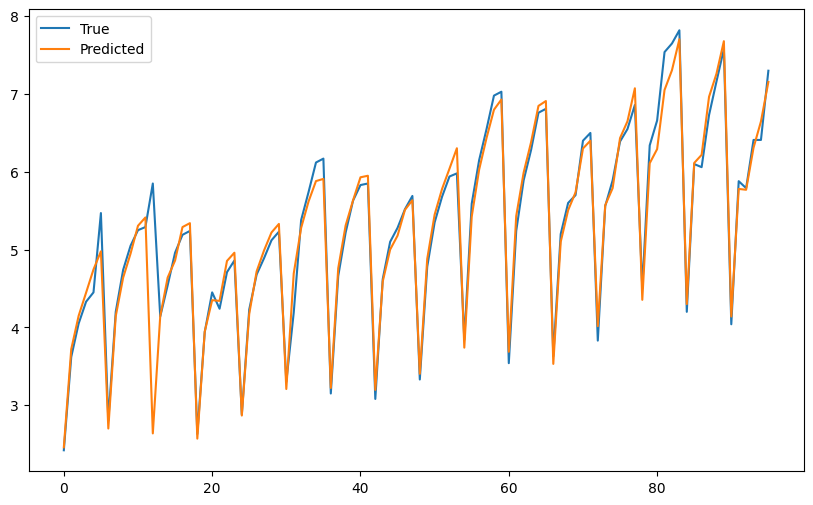

In [28]:

import matplotlib.pyplot as plt  # Importing the matplotlib library for plotting

# Get the predictions using the best model
y_pred = best_model_split.predict(X)  # Making predictions on the input data

# Plot the true and predicted values
plt.figure(figsize=(10, 6))  # Creating a plot with a specified size
plt.plot(y, label='True')  # Plotting the true values
plt.plot(y_pred, label='Predicted')  # Plotting the predicted values
plt.legend()  # Adding a legend to the plot
plt.show()  # Displaying the plot
